---
layout: default
categories: "DataScience"
permalink: /:categories/:title
title: "ML Walk-through 1 - Part 5 of 5"
---

# Model: Best Model for Balanced_Accuracy

In this 5 part walk-through, I'll demonstrate a simple Machine Learning project to build a classifier model.

Tis step is the result of multiple iterative improvements the model underwent as per the insights from EDA, benchmark classifier. Iterations were measured and compared based on the metric we selected based on the insights from:

1. Project scope/Problem literature review
2. Benchmark model
3. Exploratory data analysis.
<!--end-excerpt-->

ML Walk-through Series:

1. Project Scoping and Data Collection
2. Initial Model
3. Exploratory Data Analysis
4. Data Processing
5. Final Model


## 1.a. Import: Libraries

In [1]:
#data organizing
import pandas #storage
import numpy as np #data-type conversion
from os import getcwd

#scaling and encoding
from sklearn.preprocessing import StandardScaler

#dimensionality reduction/feature selection
from sklearn.feature_selection import SelectKBest #count of k best features chi2
from sklearn.feature_selection import mutual_info_classif

#preprocessing - data splitting
from sklearn.model_selection import train_test_split

#classifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import GaussianNB

from sklearn.svm import SVC

from sklearn.ensemble import StackingClassifier

#classification result - statistical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

#classifier result - graphical
from sklearn.model_selection import learning_curve

from sklearn.exceptions import *

## 1.b. Import: Dataset

In [2]:
#dtype changed from int64 to int32 to save space and speed up computation, no data was lost
def cvDefPay(prediction):
    mapper = {0: False, 1: True}
    return mapper.get(prediction)

url = getcwd() + '\\default of credit card clients.xls'
ccd = pandas.read_excel(io = url, \
                        sheet_name='Data', header = 1, index_col = 0, \
                        dtype = {'LIMIT_BAL': np.int32, 'AGE': np.int32, 'BILL_AMT1': np.int32, 'BILL_AMT2': np.int32, 'BILL_AMT3': np.int32, 'BILL_AMT4': np.int32, 'BILL_AMT5': np.int32, 'BILL_AMT6': np.int32, 'PAY_AMT1': np.int32, 'PAY_AMT2': np.int32, 'PAY_AMT3': np.int32, 'PAY_AMT4': np.int32, 'PAY_AMT5': np.int32, 'PAY_AMT6': np.int32}, \
                       converters = {'default payment next month': cvDefPay})

In [3]:
ccd.rename(columns = {'PAY_0': 'PAY_1'}, inplace = True)
ccd.rename(columns = {'default payment next month': 'default_payment_next_month'}, inplace = True)

## 2.a Feature Engineering

#### 1. PAY_1 to PAY_6

In [4]:
ccdr = pandas.read_excel(io = url, 
                        sheet_name='Data', header = 1, index_col = 0)
ccdr.rename(columns = {'PAY_0': 'PAY_1'}, inplace = True)

In [5]:
ccdrHistory = ccdr[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]
ccdrHistoryMode = ccdrHistory.mode(axis = 'columns')
ccdrHistorySeverest = ccdrHistoryMode.apply(func = max, axis = 'columns')
ccd['PAY_MODE_SEVEREST'] = ccdrHistorySeverest

#### 2. BILL_AMT1 to BILL_AMT6

In [6]:
ccdSpent = ccd[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']]
ccd['BILL_AMT_MEAN'] = np.int32(ccdSpent.mean(axis = 'columns').round())

#### 3. PAY_AMT1 to PAY_AMT6

In [7]:
ccdSettled = ccd[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]
ccd['PAY_AMT_MEAN'] = np.int32(ccdSettled.mean(axis = 'columns').round())

## 2.b. Normalization

Scaling: Only to reduce the effect of very large continuous variables (in distance based estimators).

Normalization: Also reduce the effect of skewness in variables.

No need in Decision Trees

In [8]:
varsToScale = ['LIMIT_BAL', 'AGE', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 
               'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'BILL_AMT_MEAN', 'PAY_AMT_MEAN']
scaler = StandardScaler(copy = True)

In [9]:
for var in varsToScale:
    ccd[var] = scaler.fit_transform(ccd[var].values.reshape(-1, 1))


## 2.c. Feature Selection

In [10]:
ccdY = pandas.DataFrame(ccd['default_payment_next_month'])
ccdX = ccd.drop(['default_payment_next_month'], axis = 'columns')

In [11]:
featureFilter = SelectKBest(score_func = mutual_info_classif, k = np.int32(len(ccdX.columns) * 0.75))
featureFilter.fit(X = ccdX, y = ccdY.values.ravel())
filteredColumnsIndices = featureFilter.get_support(indices = True)

ccdXdr = ccdX.iloc[:, filteredColumnsIndices]

## 2.d. Encoding

OneHotEncoding should be done after dimensionality reduction to ensure that one of the categories of a variable isn't dropped during feature selection, which could have been the case if OneHotEncoder was used before Feature Selection.

No need to run any encoder since:

1. The dataset's relevant categorical variables are pre-encoded via OrdinalEncoder.
2. All of the categorical variables' categories have some difference in distribution in correlation with the target variable, so OneHotEncoder should not be used.

## 3.a. Data Splitting

Data is split before oversampling to avoid synthetic datapoints in test dataset.

Test dataset is separated even though GridSearchCV uses Stratified K-Fold cross-validation so that model's accuracy can be tested independently.

In [12]:
trainX, testX, trainY, testY = train_test_split(ccdXdr, ccdY, test_size = 0.25, stratify = ccdY, random_state = 44)

## 4. Classification: StackingClassifier

How did I come up with this ensemble model with these specific parameters?

It's the outcome of multiple attempts at model building with various algorithms and parameters, the individual algorithms and parameters composing the ensemble algorithm are, what I found to be 'the more successful' models.


In [13]:
clfRF = RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                               criterion='entropy', max_depth=9.5, max_features='auto',
                               max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0,
                               min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                               oob_score=False, random_state=39, verbose=0, warm_start=False)

clfLG = LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=-1, penalty='none',
                   random_state=44, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

clfTrue = GaussianNB(priors=None, var_smoothing=1e-09)

clfFalse = SVC(cache_size = 500, max_iter = 1000, random_state = 44, kernel = 'linear', C = 10,
               class_weight = {True: 1.25, False: 1.0})

classifier = StackingClassifier(estimators = [('clfRF', clfRF), 
                                              ('clfTrue', clfTrue),
                                              ('clfFalse', clfFalse)],
                              final_estimator = clfLG,
                              n_jobs = -1,
                              passthrough = True)

In [14]:
classifier.fit(trainX, trainY.values.ravel())

StackingClassifier(estimators=[('clfRF',
                                RandomForestClassifier(bootstrap=False,
                                                       class_weight='balanced',
                                                       criterion='entropy',
                                                       max_depth=9.5, n_jobs=-1,
                                                       random_state=39)),
                               ('clfTrue', GaussianNB()),
                               ('clfFalse',
                                SVC(C=10, cache_size=500,
                                    class_weight={False: 1.0, True: 1.25},
                                    kernel='linear', max_iter=1000,
                                    random_state=44))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      max_iter=1000, n_jobs=-1,
                                                      pena

## 4.a. Classification Result - Statistical

In [15]:
classifier.score(trainX, trainY)

0.8015111111111111

In [16]:
classifier.score(testX, testY)

0.7614666666666666

In [17]:
predictY = classifier.predict(testX)
print(classification_report(testY, predictY))

              precision    recall  f1-score   support

       False       0.88      0.81      0.84      5841
        True       0.47      0.60      0.53      1659

    accuracy                           0.76      7500
   macro avg       0.67      0.70      0.68      7500
weighted avg       0.79      0.76      0.77      7500



In [18]:
roc_auc_score(testY, predictY)

0.7031458731737642

In [19]:
pandas.DataFrame(
    confusion_matrix(testY, predictY),
    columns=['Predicted | Not Defaulter', 'Defaulter'],
    index=['Correct | Not Defaulter', 'Defaulter'])

,Predicted | Not Defaulter,Defaulter
Correct | Not Defaulter,4718,1123
Defaulter,666,993


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), scoring=None):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,), dtype={int, float}
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))

    scoring : str or callable, default=None
        A str (see model evaluation documentation) or a scorer callable object / function with signature scorer(estimator, X, y).
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,scoring=scoring,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

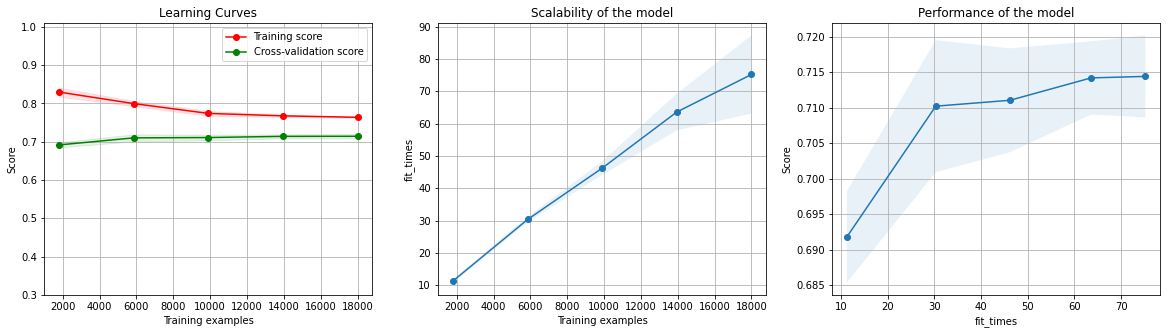

In [21]:
plot_learning_curve(estimator=classifier, title="Learning Curves", X=trainX, y=trainY, ylim=(0.3, 1.01),
                    cv=5, scoring="balanced_accuracy", n_jobs=-1).show()

## To conclude

Comparing the cross validation scores of the benchmark and best classifier, the improvement is minor, hence we did not achieve much improvement overall.

When looking at the training scores of the benchmark and best classifier, we see that the best classifier had much lower head-room for improvement, this lessening of head-room is likely due to following reasons:

1. Current model can't match the DecisionTree's tendency to fit the training data very well.
2. Feature engineering can be improved (perhaps dropping less insightful features and creating feature highlighting specific trends from pre-existing highly insightful features?).
3. Given the imbalance between classes, their relative importance and their datapoints' differences, a different ensemble model based around those insights could be more successful (perhaps clustering along-with individual models targeting individual classes?).

Lastly, comparing benchmark and best models' chosen metric for the problem (macro average recall aka balanced accuracy):

1. Benchmark -> 0.62
2. Best balanced accuracy -> 0.70

The improvement is neither significant nor insignificant and there is room for more.

### Something extra

__SHAP__ and __LIME__ are interesting topics that I've not covered here, which might prove well worth the time needed to understand those topics.


<sup><sub>
Posted: 18th September, 2021, 13:20 UTC+5:30  
</sub></sup>